<a href="https://colab.research.google.com/github/mumikam/Hyperspectral/blob/main/Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Study on Hyperspectral Images
### Author: Kamila Muminova

## Cloning the repository from Github

In [1]:
!git clone https://github.com/mumikam/Hyperspectral.git

Cloning into 'Hyperspectral'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 23 (delta 0), reused 3 (delta 0), pack-reused 16
Receiving objects: 100% (23/23), 140.21 MiB | 27.09 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## Installing and importing needed libraries

In [ ]:
!pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 1.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import math
import sys
import time
import csv
import scipy.io as sio
import spectral
from IPython.display import Image
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from scipy.special import legendre
from scipy.linalg import svd

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
#Loading the mat file

def loadData(dataPath, labelPath):
    rawData = sio.loadmat(dataPath)
    dataName = list(rawData.keys())[3]
    data = rawData[dataName]
    rawLabels = sio.loadmat(labelPath)
    labelName = list(rawLabels.keys())[3]
    labels = rawLabels[labelName]

    return data, labels

In [ ]:
IndianPines = "/content/Hyperspectral/data/Indian_pines_corrected.mat"
IndianPines_GroundTruth = "/content/Hyperspectral/data/Indian_pines_gt.mat"

PaviaUniversity = "/content/Hyperspectral/data/PaviaU.mat"
PaviaUniversity_GroundTruth = "/content/Hyperspectral/data/PaviaU_gt.mat"

Salinas = "/content/Hyperspectral/data/Salinas_corrected.mat"
Salinas_GroundTruth = "/content/Hyperspectral/data/Salinas_gt.mat"

Botswana = "/content/Hyperspectral/data/Botswana.mat"
Botswana_GroundTruth = "/content/Hyperspectral/data/Botswana_gt.mat"

CurrentImage = IndianPines
CurrentImage_GroundTruth = IndianPines_GroundTruth

In [ ]:
X, y = loadData(CurrentImage, CurrentImage_GroundTruth) #Loading the Indian Pines data set

In [ ]:
#Coordinates of all non-zero pixels from ground truth gathered
test = []
for i in range(y.shape[0]):
  for j in range(y.shape[1]):
    if y[i][j] != 0:
      test.append((i,j))

# 1- Random Dictionary + OMP

## Multiple Coefficient OMP

In [ ]:
for csv_it in range(1, 21):

  allPoints = np.zeros(shape=(X.shape[2], len(test)))
  for layer in range(X.shape[2]):
    for idx in range(len(test)):
      allPoints[layer][idx] = X[test[idx][0], test[idx][1], layer]

  normalized_all = allPoints

  test_idxs = [i for i in range(len(test))]
  train_idxs = [test_idxs.pop(random.randrange(len(test_idxs))) for _ in range(500)]

  testDict = np.zeros(shape=(X.shape[2], len(test_idxs)))
  for layer in range(X.shape[2]):
    for idx in range(len(test_idxs)):
      testDict[layer][idx] = normalized_all[layer, test_idxs[idx]]

  trainDict = np.zeros(shape=(X.shape[2], len(train_idxs)))
  for layer in range(X.shape[2]):
    for idx in range(len(train_idxs)):
      trainDict[layer][idx] = normalized_all[layer, train_idxs[idx]]

  max_coefs = 20 #atoms

  ErrorDict_1 = {}

  for n_nonzero_coefs in range(1, max_coefs+1):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, normalize=False)
    A_tilda = np.zeros(shape=testDict.shape)

    for i in range(testDict.shape[1]):
      omp.fit(trainDict, testDict[:,i:i+1])
      A_tilda[:, i] = np.dot(trainDict,  omp.coef_)

    subt = np.subtract(testDict, A_tilda)
    ErrorDict_1[n_nonzero_coefs] = np.mean(np.absolute(subt))
    print("Iteration %d error %f" % (n_nonzero_coefs, ErrorDict_1[n_nonzero_coefs]))

  print('CSV=====>>> '+str(csv_it))
  df = pd.DataFrame(ErrorDict_1.items(), columns=['Iteration', 'Error'])
  df.to_csv('/drive/My Drive/Kamila_Thesis_V2/Random_OMP/'+str(csv_it)+'.csv')

# 2- HDMR + OMP

In [ ]:
def hdmr(trainDict):
  first_ones = np.ones((1, trainDict.shape[0]))
  second_ones = np.ones((trainDict.shape[1], 1))

  m0 = (np.dot(np.dot(first_ones, trainDict), second_ones))[0][0] / (trainDict.shape[0] * trainDict.shape[1])
  m1 = np.dot(trainDict, second_ones)/ trainDict.shape[1] - m0
  m2 = np.dot(trainDict.transpose(), first_ones.transpose())/ trainDict.shape[0] - m0

  denoised_trainDict = np.dot(np.dot(m0, first_ones.transpose()), second_ones.transpose()) + np.dot(m1, second_ones.transpose()) + np.dot(first_ones.transpose(), m2.transpose())

  return denoised_trainDict

In [ ]:
for csv_it in range(1, 11):

  allPoints = np.zeros(shape=(X.shape[2], len(test)))
  for layer in range(X.shape[2]):
    for idx in range(len(test)):
      allPoints[layer][idx] = X[test[idx][0], test[idx][1], layer]

  normalized_all = allPoints

  test_idxs = [i for i in range(len(test))]
  train_idxs = [test_idxs.pop(random.randrange(len(test_idxs))) for _ in range(500)]

  testDict = np.zeros(shape=(X.shape[2], len(test_idxs)))
  for layer in range(X.shape[2]):
    for idx in range(len(test_idxs)):
      testDict[layer][idx] = normalized_all[layer, test_idxs[idx]]

  trainDict = np.zeros(shape=(X.shape[2], len(train_idxs)))
  for layer in range(X.shape[2]):
    for idx in range(len(train_idxs)):
      trainDict[layer][idx] = normalized_all[layer, train_idxs[idx]]

  denoised_trainDict = hdmr(trainDict)

  max_coefs = 20 #atoms

  ErrorDict_2 = {}
  #Running omp for 1 to 20 pixels
  for n_nonzero_coefs in range(1, max_coefs + 1):

    A_tilda = np.zeros(shape=testDict.shape)

    for i in range(testDict.shape[1]):
      omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
      omp.fit(denoised_trainDict, testDict[:,i:i+1])

      A_tilda[:, i] = np.dot(denoised_trainDict,  omp.coef_) #This should be denoised_trainDict, not testDict or traindict!!

    subt = np.subtract(testDict, A_tilda)
    ErrorDict_2[n_nonzero_coefs] = np.mean(np.absolute(subt))
    print("Iteration %d error %f" % (n_nonzero_coefs, ErrorDict_2[n_nonzero_coefs]))

  print('CSV=====>>> '+str(csv_it))
  df = pd.DataFrame(ErrorDict_2.items(), columns=['Iteration', 'Error'])
  df.to_csv('/drive/My Drive/Kamila_Thesis_V2/HDMR_OMP/'+str(csv_it)+'.csv')

# 3- Random Dictionary + OMP + K-SVD

In [ ]:
for csv_it in range(1, 11):
  allPoints = np.zeros(shape=(X.shape[2], len(test)))
  for layer in range(X.shape[2]):
    for idx in range(len(test)):
      allPoints[layer][idx] = X[test[idx][0], test[idx][1], layer]

  normalized_all = allPoints

  test_idxs = [i for i in range(len(test))]
  train_idxs = [test_idxs.pop(random.randrange(len(test_idxs))) for _ in range(165)]

  testDict = np.zeros(shape=(X.shape[2], len(test_idxs)))
  for layer in range(X.shape[2]):
    for idx in range(len(test_idxs)):
      testDict[layer][idx] = normalized_all[layer, test_idxs[idx]]

  trainDict = np.zeros(shape=(X.shape[2], len(train_idxs)))
  for layer in range(X.shape[2]):
    for idx in range(len(train_idxs)):
      trainDict[layer][idx] = normalized_all[layer, train_idxs[idx]]

  max_coefs = 20 #atoms 1 to 10
  max_it = 3 #for k-svd

  ErrorDict_3 = {}

  for coefs in range(1, max_coefs+1):
    for it in range(max_it):
      # Sparse coding step using OMP algorithm
      X_sparse = np.zeros(shape=(trainDict.shape[1], testDict.shape[1]))
      A_tilda = np.zeros(shape=testDict.shape) #Recreated hyperspectral image
      omp = OrthogonalMatchingPursuit(n_nonzero_coefs=coefs, normalize=False)

      for i in range(testDict.shape[1]):
        omp.fit(trainDict, testDict[:,i:i+1])
        coef = omp.coef_
        X_sparse[:, i] = coef
        (idx_r,) = coef.nonzero()

      #K-SVD Start
      for j in range(165):
        # Find nonzero elements in column j of X_sparse
        I = np.nonzero(X_sparse[j, :])[0]

        if len(I) == 0:
          continue

        # Update dictionary column j
        E = testDict[:, I] - np.dot(trainDict, X_sparse[:, I]) + np.outer(trainDict[:, j], X_sparse[j, I])
        U, s, Vt = svd(E)
        trainDict[:, j] = U[:, 0]
        X_sparse[j, I] = s[0] * Vt[0, :]
        #K-SVD End

    A_tilda =  np.dot(trainDict, X_sparse)
    subt = np.subtract(testDict, A_tilda)
    ErrorDict_3[coefs] = np.mean(np.absolute(subt))
    print("Iteration %d error %f" % (coefs, ErrorDict_3[coefs]))

  print('CSV=====>>> '+str(csv_it))
  df = pd.DataFrame(ErrorDict_3.items(), columns=['Iteration', 'Error'])
  df.to_csv('/drive/My Drive/Kamila_Thesis/Botswana/KSVD_OMP/'+str(csv_it)+'.csv')

# 4- HDMR + OMP + K-SVD

In [ ]:
for csv_it in range(18, 21):

  allPoints = np.zeros(shape=(X.shape[2], len(test)))
  for layer in range(X.shape[2]):
    for idx in range(len(test)):
      allPoints[layer][idx] = X[test[idx][0], test[idx][1], layer]

  normalized_all = allPoints

  test_idxs = [i for i in range(len(test))]
  train_idxs = [test_idxs.pop(random.randrange(len(test_idxs))) for _ in range(500)]

  testDict = np.zeros(shape=(X.shape[2], len(test_idxs)))
  for layer in range(X.shape[2]):
    for idx in range(len(test_idxs)):
      testDict[layer][idx] = normalized_all[layer, test_idxs[idx]]

  trainDict = np.zeros(shape=(X.shape[2], len(train_idxs)))
  for layer in range(X.shape[2]):
    for idx in range(len(train_idxs)):
      trainDict[layer][idx] = normalized_all[layer, train_idxs[idx]]

  denoised_trainDict = hdmr(trainDict)

  max_coefs = 20 #atoms 1 to 20
  max_it = 3 #for k-svd

  ErrorDict_4 = {}

  for coefs in range(1, max_coefs+1):
    for it in range(max_it):
      # Sparse coding step using OMP algorithm
      X_sparse = np.zeros(shape=(denoised_trainDict.shape[1], testDict.shape[1]))
      A_tilda = np.zeros(shape=testDict.shape) #Recreated hyperspectral image
      omp = OrthogonalMatchingPursuit(n_nonzero_coefs=coefs, normalize=False)

      for i in range(testDict.shape[1]):
        omp.fit(denoised_trainDict, testDict[:,i:i+1])
        coef = omp.coef_
        X_sparse[:, i] = coef
        (idx_r,) = coef.nonzero()

      #K-SVD Start
      for j in range(500):
        # Find nonzero elements in column j of X_sparse
        I = np.nonzero(X_sparse[j, :])[0]

        if len(I) == 0:
          continue

        # Update dictionary column j
        E = testDict[:, I] - np.dot(denoised_trainDict, X_sparse[:, I]) + np.outer(denoised_trainDict[:, j], X_sparse[j, I])
        U, s, Vt = svd(E)
        denoised_trainDict[:, j] = U[:, 0]
        X_sparse[j, I] = s[0] * Vt[0, :]
        #K-SVD End

    A_tilda =  np.dot(denoised_trainDict, X_sparse)
    subt = np.subtract(testDict, A_tilda)
    ErrorDict_4[coefs] = np.mean(np.absolute(subt))
    print("Iteration %d error %f" % (coefs, ErrorDict_4[coefs]))

  print('CSV=====>>> '+str(csv_it))
  df = pd.DataFrame(ErrorDict_4.items(), columns=['Iteration', 'Error'])
  df.to_csv('/drive/My Drive/Kamila_Thesis/Salinas/HDMR_KSVD_OMP/'+str(csv_it)+'.csv')

# Result Graphs

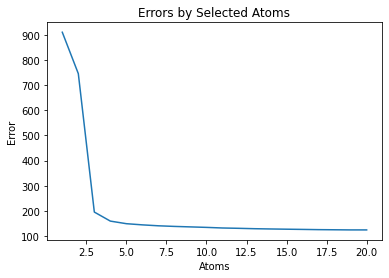

In [ ]:
coefs = list(ErrorDict_1.keys())           # list() needed for python 3.x
errors = list(ErrorDict_1.values())

plt.plot(coefs,errors)
plt.title('Errors by Selected Atoms')
plt.xlabel('Atoms')
plt.ylabel('Error')
plt.show()

In [ ]:
ErrorDict_1

{1: 910.9468707488426,
 2: 746.1440990614329,
 3: 194.95073159263902,
 4: 158.98446387922354,
 5: 148.6760844918217,
 6: 143.99337763434622,
 7: 140.2956548799757,
 8: 137.84022049699144,
 9: 135.90543553125076,
 10: 133.96455562547018,
 11: 131.5552973279541,
 12: 130.2710081596276,
 13: 128.71596505351542,
 14: 127.63630749527456,
 15: 126.73558154074794,
 16: 125.8995539025488,
 17: 124.97936937206939,
 18: 124.45996832137376,
 19: 123.91585034997728,
 20: 123.88609809635825}

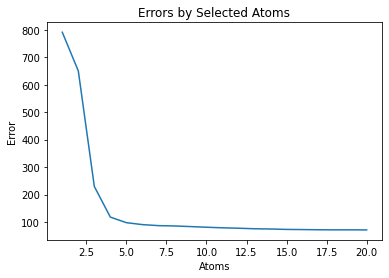

In [ ]:
coefs = list(ErrorDict_2.keys())           # list() needed for python 3.x
errors = list(ErrorDict_2.values())

plt.plot(coefs,errors)
plt.title('Errors by Selected Atoms')
plt.xlabel('Atoms')
plt.ylabel('Error')
plt.show()

In [ ]:
ErrorDict_2

{1: 791.0803963681227,
 2: 650.1172414382615,
 3: 229.3470258535822,
 4: 117.88401980879837,
 5: 97.68165316445724,
 6: 90.55102113170962,
 7: 86.89510205219268,
 8: 85.67650405217695,
 9: 83.41816901461115,
 10: 81.02486733664138,
 11: 78.89070660479464,
 12: 77.42189469828872,
 13: 75.49087544730818,
 14: 74.57198230538947,
 15: 73.10143880310014,
 16: 72.51462684618579,
 17: 71.84680085766838,
 18: 71.48208366237985,
 19: 71.58350206361875,
 20: 71.26066063085504}

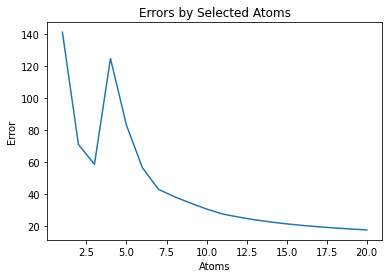

In [ ]:
coefs = list(ErrorDict_3.keys())           # list() needed for python 3.x
errors = list(ErrorDict_3.values())

plt.plot(coefs,errors)
plt.title('Errors by Selected Atoms')
plt.xlabel('Atoms')
plt.ylabel('Error')
plt.show()

In [ ]:
ErrorDict_3

{1: 141.38279127258295,
 2: 71.22947642673536,
 3: 58.796814116114405,
 4: 124.98319922325842,
 5: 83.18635227836141,
 6: 56.55668878873942,
 7: 43.11286442106163,
 8: 38.52014227942159,
 9: 34.53779826815425,
 10: 30.83862047694877,
 11: 27.72403260047965,
 12: 25.785030837734375,
 13: 24.120627555424807,
 14: 22.734527611489096,
 15: 21.558825598419972,
 16: 20.58465007764617,
 17: 19.721500402000256,
 18: 18.989580238065297,
 19: 18.359152138038443,
 20: 17.779818687934338}

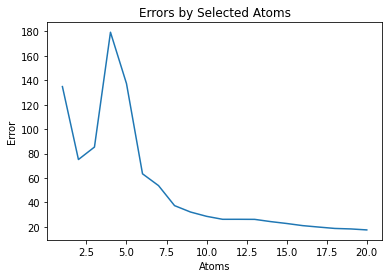

In [ ]:
coefs = list(ErrorDict_4.keys())           # list() needed for python 3.x
errors = list(ErrorDict_4.values())

plt.plot(coefs,errors)
plt.title('Errors by Selected Atoms')
plt.xlabel('Atoms')
plt.ylabel('Error')
plt.show()

In [ ]:
ErrorDict_4

{1: 134.81110279377768,
 2: 75.09537746787382,
 3: 85.2969749995394,
 4: 179.30515653392126,
 5: 137.2406629901781,
 6: 63.39854408704721,
 7: 53.72898888130764,
 8: 37.34259411978865,
 9: 32.08931736716799,
 10: 28.58443617896466,
 11: 26.144929942615633,
 12: 26.15627897040408,
 13: 26.09852023419273,
 14: 24.26248759840471,
 15: 22.718513841842572,
 16: 20.966528335543362,
 17: 19.788398433973168,
 18: 18.66923965256337,
 19: 18.26017827764801,
 20: 17.4572974936618}

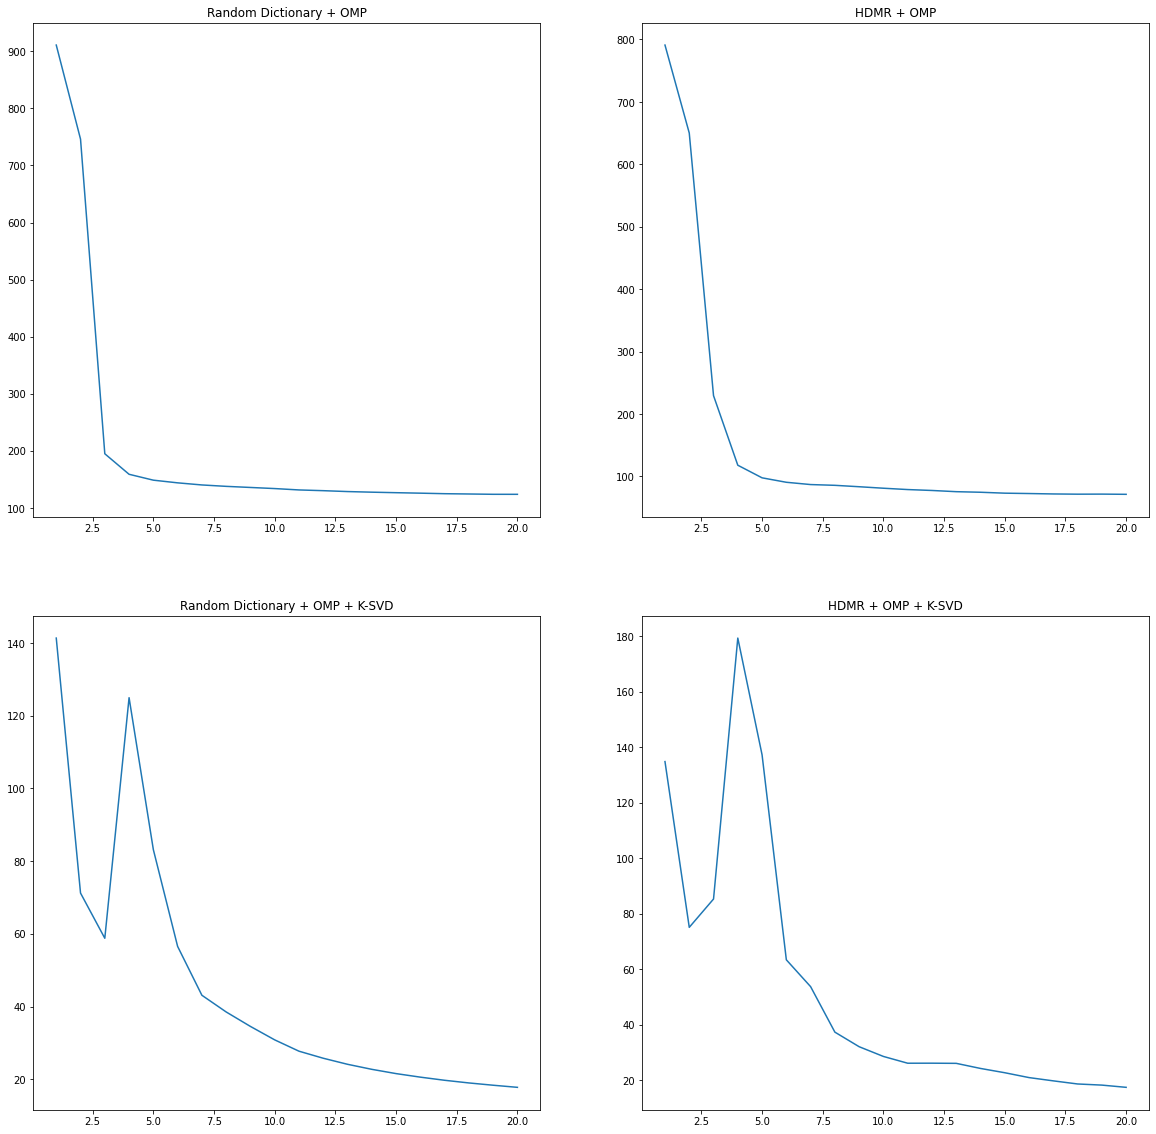

In [ ]:
coefs1 = list(ErrorDict_1.keys())
errors1 = list(ErrorDict_1.values())

coefs2 = list(ErrorDict_2.keys())
errors2 = list(ErrorDict_2.values())

coefs3 = list(ErrorDict_3.keys())
errors3 = list(ErrorDict_3.values())

coefs4 = list(ErrorDict_4.keys())
errors4 = list(ErrorDict_4.values())

plt.rcParams["figure.figsize"] = (20,20)

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(coefs1, errors1)
axis[0, 0].set_title("Random Dictionary + OMP")

# For Cosine Function
axis[0, 1].plot(coefs2, errors2)
axis[0, 1].set_title("HDMR + OMP")

# For Tangent Function
axis[1, 0].plot(coefs3, errors3)
axis[1, 0].set_title("Random Dictionary + OMP + K-SVD")

# For Tanh Function
axis[1, 1].plot(coefs4, errors4)
axis[1, 1].set_title("HDMR + OMP + K-SVD")

# Combine all the operations and display
plt.show()

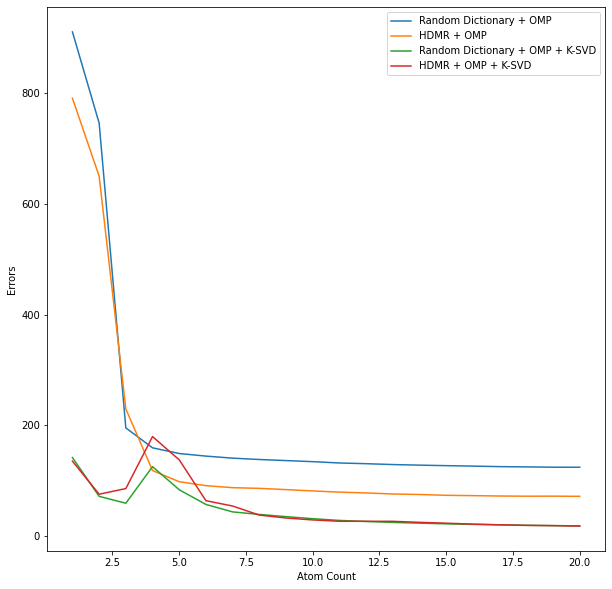

In [ ]:
coefs1 = list(ErrorDict_1.keys())
errors1 = list(ErrorDict_1.values())

coefs2 = list(ErrorDict_2.keys())
errors2 = list(ErrorDict_2.values())

coefs3 = list(ErrorDict_3.keys())
errors3 = list(ErrorDict_3.values())

coefs4 = list(ErrorDict_4.keys())
errors4 = list(ErrorDict_4.values())

plt.plot(coefs1, errors1, label = "Random Dictionary + OMP")
plt.plot(coefs2, errors2, label = "HDMR + OMP")
plt.plot(coefs3, errors3, label = "Random Dictionary + OMP + K-SVD")
plt.plot(coefs4, errors4, label = "HDMR + OMP + K-SVD")

plt.rcParams["figure.figsize"] = (20,20)

plt.xlabel("Atom Count")
plt.ylabel("Errors")
plt.legend()
#plt.title('Error rate')
# Combine all the operations and display
plt.show()